# (1+1)-ES in Python
An Evolutionary Strategy (ES) is an optimisation algorithm inspire day biological evolution. You have a candidate solution, you mutate it, and you keep the better one. Repeat until you find the minimum. 

Every generation, you have 1 parent and make 1 child: 

Child = parent + sigma * random_noise 

Every generation you add Gaussian noise to your current solution to create a child. 
If the child is better -> it becomes the new parent. Otherwise, discard it. 
This is called elitist selection (you never accept a worse solution).

  #Q  why Gaussian Noise specifically? it is used because of its shape, most mutations are small (near the centre of the bell curve), with occasional large ones (in the tails). This mirror how biological mutations work, and it has a useful mathematical property: it’s the only distribution that’s symmetric and gets its shape entirely from one parameter (σ). Changing σ scales the whole distribution without changing its character. 

sigma (σ) is the standard deviation of the noise — it controls the step size, it controls how far you jump. 
* σ too large: you jump all over the search space randomly, rarely landing near the current best → slow progress
* σ too small: you take tiny steps and converge prematurely to whatever local area you're already in → get stuck
* σ just right: you explore enough to improve, but not so much that you're just random walking

#Q how do you set σ?
#Q how do you change it over time as you get closer to the optimum (where you need smaller steps)?

Key: no single fixed σ is right for the whole run -> Early on, when you're far from the optimum, you want large steps to cover ground quickly. Later, when you're close, you need small steps for precision. A fixed σ is always compromising — which is exactly why Rechenberg's rule from the previous exercise exists.

3 steps: 
1. Mutate -> take your current point, add random Gaussian noise
2. Evaluate -> score the new point 
3. Select -> if it’s better, move there. If not, stay put 

In [10]:
pip install cma -q


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cma

In [12]:
# Benchmark functions 
def sphere (x):
    return np.sum(x**2)
def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [13]:
def one_plus_one_es_classic(fitness_function, N=10, sigma=0.5, max_generations=10000):
    x = np.random.uniform(-5, 5, N)
    history = []

    for _ in range(max_generations):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_classic(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.14530533903222
rastrigin Best fitness: 54.521678067343046


In [14]:
def one_plus_one_es_success_rule(fitness_function, N=10, sigma=0.5, max_generations=2000):
    x = np.random.uniform(-5, 5, N)
    tau = 1.5
    k = 20
    success_count = 0
    history = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
            success_count += 1

        if t % k == 0:
            success_rate = success_count / k
            if success_rate > 1/5:
                sigma *= tau
            else:
                sigma /= tau
            success_count = 0

        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_success_rule(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 3.3077854873342246e-24
rastrigin Best fitness: 59.69733133623221


In [15]:
def mu_plus_lambda_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200, sigma=0.3):
    population = np.random.randn(mu, dim)
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            parent = population[np.random.randint(mu)]
            child = parent + sigma * np.random.randn(dim)
            offspring.append(child)

        combined = np.vstack([population, offspring])
        fitness = np.array([fitness_fn(ind) for ind in combined])
        best_indices = np.argsort(fitness)[:mu]
        population = combined[best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = mu_plus_lambda_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.15320850135208053
rastrigin Best fitness: 23.33086729881461


In [16]:
def self_adaptive_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200):
    tau = 1 / np.sqrt(dim)
    population = [(np.random.randn(dim), 0.5) for _ in range(mu)]
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            x, sigma = population[np.random.randint(mu)]
            sigma_prime = sigma * np.exp(tau * np.random.randn())
            sigma_prime = max(sigma_prime, 1e-8)
            x_prime = x + sigma_prime * np.random.randn(dim)
            offspring.append((x_prime, sigma_prime))

        combined = population + offspring
        fitness = [fitness_fn(ind[0]) for ind in combined]
        best_indices = np.argsort(fitness)[:mu]
        population = [combined[i] for i in best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = self_adaptive_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 1.3535177722136732e-15
rastrigin Best fitness: 7.959667418927296


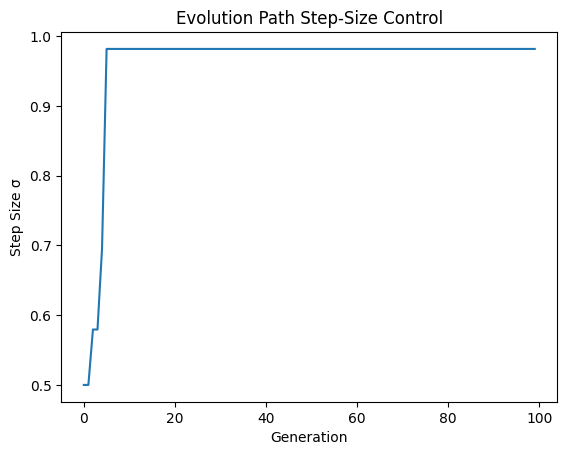

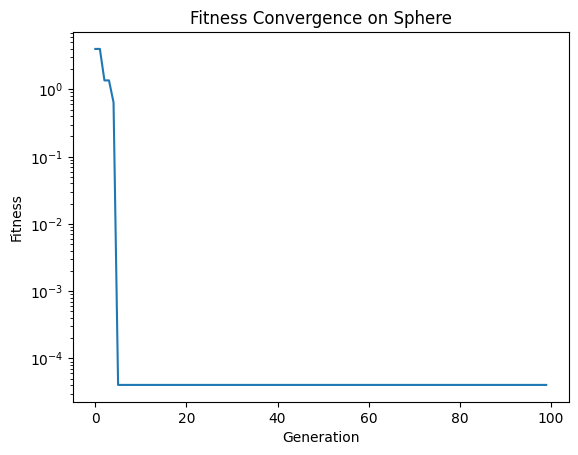

In [17]:
def evolution_path_es(generations=100):
    x = 2.0
    sigma = 0.5
    p_sigma = 0.0
    c_sigma = 0.3
    d_sigma = 1.0
    expected_norm = np.sqrt(2/np.pi)

    sigma_vals = []
    fitness_vals = []

    for _ in range(generations):
        z = np.random.randn()
        x_candidate = x + sigma * z

        # Elitist selection
        if sphere(x_candidate) < sphere(x):
            x = x_candidate
            p_sigma = (1 - c_sigma) * p_sigma + np.sqrt(c_sigma*(2-c_sigma)) * z
            sigma *= np.exp((c_sigma/d_sigma) * (abs(p_sigma)/expected_norm - 1))

        sigma_vals.append(sigma)
        fitness_vals.append(sphere(x))

    return sigma_vals, fitness_vals

sigma_vals, fitness_vals = evolution_path_es()

# Plot step size
plt.figure()
plt.plot(sigma_vals)
plt.xlabel("Generation")
plt.ylabel("Step Size σ")
plt.title("Evolution Path Step-Size Control")
plt.show()

# Plot fitness (log scale)
plt.figure()
plt.plot(fitness_vals)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.yscale("log")
plt.title("Fitness Convergence on Sphere")
plt.show()

In [18]:
def simple_cma_es(fitness_fn, N=10, sigma=0.5, lambda_=10, mu=5, generations=200):
    x = np.random.randn(N)
    C = np.eye(N)
    history = []

    for _ in range(generations):
        A = np.linalg.cholesky(C)
        Z = np.random.randn(lambda_, N)
        X = x + sigma * Z @ A.T
        fitnesses = np.array([fitness_fn(xi) for xi in X])
        indices = np.argsort(fitnesses)
        selected = X[indices[:mu]]
        x_mean = np.mean(selected, axis=0)

        C_update = np.zeros((N,N))
        for xi in selected:
            diff = xi - x_mean
            C_update += np.outer(diff, diff)
        C = 0.8*C + 0.2*(C_update/mu)

        if fitness_fn(x_mean) <= fitness_fn(x):
            x = x_mean

        history.append(fitness_fn(x))

    return x, history


for f in [sphere, rastrigin]:
    best, history = simple_cma_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 6.1328995315652105e-12
rastrigin Best fitness: 6.9647133996532204


In [19]:
def run_pycma(fitness_fn):
    N = 10
    initial_mean = np.random.randn(N)
    initial_sigma = 0.5

    es = cma.CMAEvolutionStrategy(initial_mean, initial_sigma)
    es.optimize(fitness_fn, maxfun=10000)
    print("Best fitness:", es.result.fbest)

print("Sphere:")
run_pycma(sphere)

print("\nRastrigin:")
run_pycma(rastrigin)

Sphere:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1020108, Mon Feb 23 13:33:30 2026)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 7.119227036875689e+00 1.0e+00 4.99e-01  5e-01  5e-01 0:00.0
    2     20 4.727396226896202e+00 1.2e+00 4.99e-01  5e-01  5e-01 0:00.0
    3     30 2.360180664042105e+00 1.3e+00 5.23e-01  5e-01  6e-01 0:00.0
  100   1000 9.567615073243098e-07 1.8e+00 7.68e-04  3e-04  3e-04 0:00.1
  200   2000 1.605199453443424e-13 2.0e+00 9.60e-07  1e-07  2e-07 0:00.1
  216   2160 1.107962066458968e-14 1.9e+00 2.67e-07  4e-08  4e-08 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 1.107962e-14 1.107962e-14 after 2160/2152 evaluations
incumbent solution: [ 4.84021451e-08  1.10725697e-08  2.34534783e-08  3.03132035e-08
 -1.75245362e-09 -8.15301272e-09  5.27377980e-08  6.76300994e-09 ...]
std deviations: [3.98663432e-08 3.62387349e-08 4.08625900e-08 4.39890836e-08
 3.96946624e-08 4.05254727e-08 3.88229800e-08

# EXERCISES 3 (a)(b)(c)

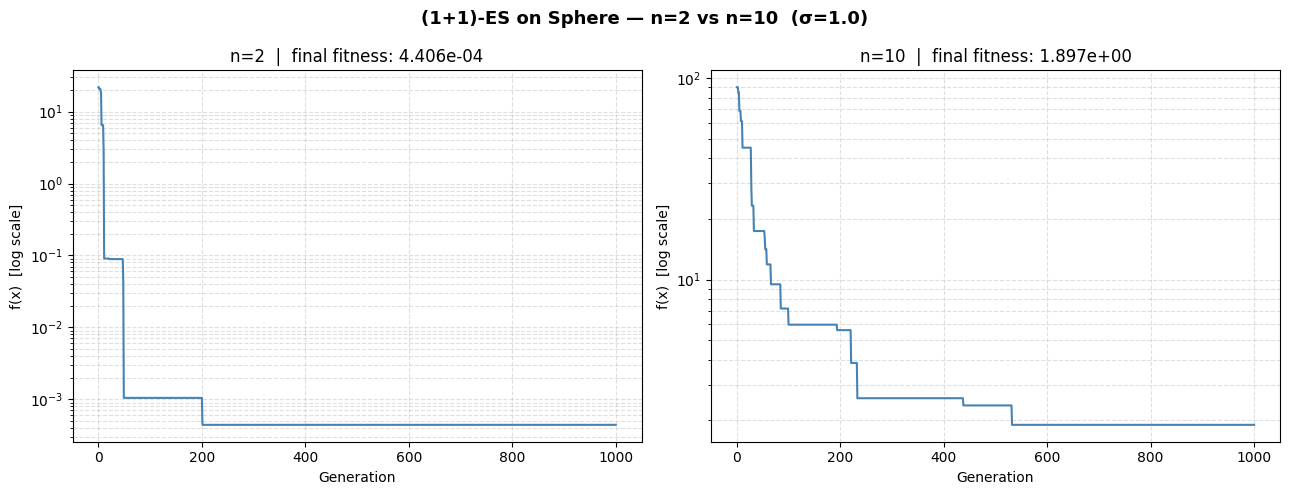

Figure 1 saved — n=2 vs n=10
  n=2  final fitness: 4.405658e-04
  n=10 final fitness: 1.897349e+00


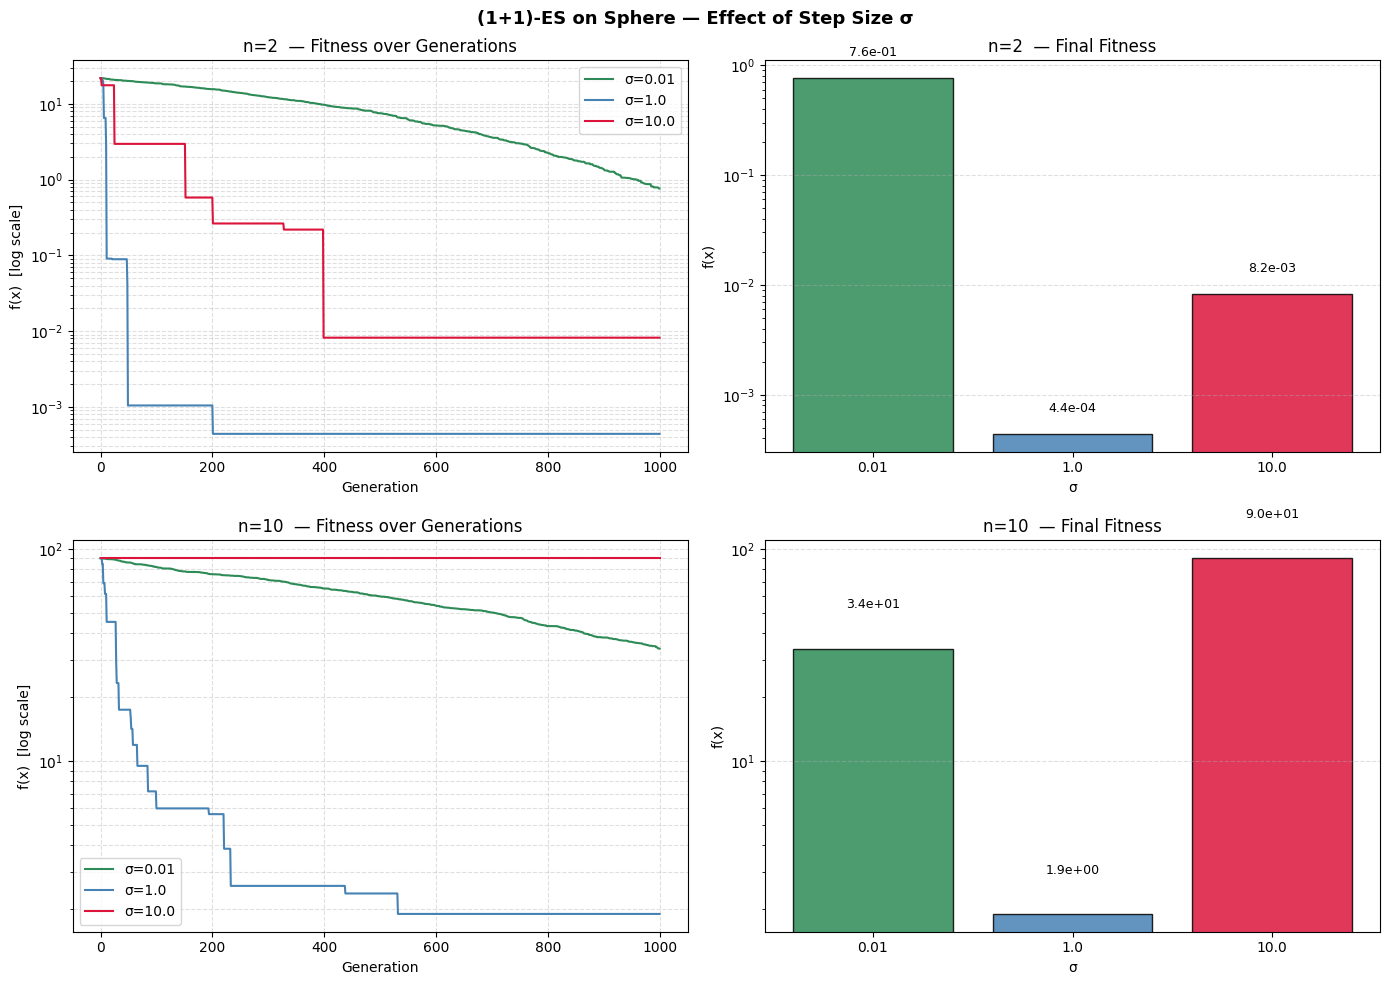


Figure 2 saved — sigma comparison

                       n=2            n=10
σ=0.01        7.631004e-01      3.377902e+01
σ=1.0         4.405658e-04      1.897349e+00
σ=10.0        8.197153e-03      9.019947e+01


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# - Sphere function -
def sphere(x):
    return np.sum(x**2)

# (a) (1+1)-ES implementation
def one_plus_one_es(fitness_fn, N, sigma, generations=1000, seed=None):
    """
    (1+1)-ES: one parent, one offspring, elitist selection.

    Parameters
    ----------
    fitness_fn  : function to minimise
    N           : number of dimensions
    sigma       : fixed step size
    generations : number of generations to run
    seed        : random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)

    x = np.random.uniform(-5, 5, N)   # random starting point
    f = fitness_fn(x)
    history = [f]

    for _ in range(generations):
        # mutate: add Gaussian noise scaled by sigma
        x_prime = x + sigma * np.random.randn(N)
        f_prime = fitness_fn(x_prime)
        # select: keep child only if it's at least as good
        if f_prime <= f:
            x, f = x_prime, f_prime
        history.append(f)
    return x, history

# (b) Test on Sphere, n=2 and n=10, 1000 generations
GENS  = 1000
SIGMA = 1.0   # neutral default for part (b)
SEED  = 42

_, hist_n2  = one_plus_one_es(sphere, N=2,  sigma=SIGMA, generations=GENS, seed=SEED)
_, hist_n10 = one_plus_one_es(sphere, N=10, sigma=SIGMA, generations=GENS, seed=SEED)

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("(1+1)-ES on Sphere — n=2 vs n=10  (σ=1.0)", fontsize=13, fontweight="bold")
for ax, hist, n in zip(axes, [hist_n2, hist_n10], [2, 10]):
    ax.semilogy(hist, color="steelblue")
    ax.set_title(f"n={n}  |  final fitness: {hist[-1]:.3e}")
    ax.set_xlabel("Generation")
    ax.set_ylabel("f(x)  [log scale]")
    ax.grid(True, which="both", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()
print("Figure 1 saved — n=2 vs n=10")
print(f"  n=2  final fitness: {hist_n2[-1]:.6e}")
print(f"  n=10 final fitness: {hist_n10[-1]:.6e}")

# (c) Compare σ ∈ {0.01, 1.0, 10.0} — both n=2 and n=10
# ============================================================================
SIGMAS = [0.01, 1.0, 10.0]
colors = {0.01: "seagreen", 1.0: "steelblue", 10.0: "crimson"}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("(1+1)-ES on Sphere — Effect of Step Size σ", fontsize=13, fontweight="bold")

for row, N in enumerate([2, 10]):
    results = {}
    for sigma in SIGMAS:
        _, hist = one_plus_one_es(sphere, N=N, sigma=sigma,
                                   generations=GENS, seed=SEED)
        results[sigma] = hist

    # fit over gen
    ax = axes[row, 0]
    for sigma, hist in results.items():
        ax.semilogy(hist, label=f"σ={sigma}", color=colors[sigma])
    ax.set_title(f"n={N}  — Fitness over Generations")
    ax.set_xlabel("Generation")
    ax.set_ylabel("f(x)  [log scale]")
    ax.legend(); ax.grid(True, which="both", linestyle="--", alpha=0.4)

    # Final fit 
    ax = axes[row, 1]
    finals     = [results[s][-1] for s in SIGMAS]
    bar_colors = [colors[s] for s in SIGMAS]
    bars = ax.bar([str(s) for s in SIGMAS], finals,
                  color=bar_colors, edgecolor="black", alpha=0.85)
    ax.set_title(f"n={N}  — Final Fitness")
    ax.set_xlabel("σ"); ax.set_ylabel("f(x)"); ax.set_yscale("log")
    for bar, val in zip(bars, finals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.5,
                f"{val:.1e}", ha="center", va="bottom", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()
plt.close()
print("\nFigure 2 saved — sigma comparison")

print("\n" + "=" * 55)
print(f"{'':10} {'n=2':>15} {'n=10':>15}")
print("=" * 55)
for sigma in SIGMAS:
    _, h2  = one_plus_one_es(sphere, N=2,  sigma=sigma, generations=GENS, seed=SEED)
    _, h10 = one_plus_one_es(sphere, N=10, sigma=sigma, generations=GENS, seed=SEED)
    print(f"σ={sigma:<6}   {h2[-1]:>15.6e}   {h10[-1]:>15.6e}")
print("=" * 55)